In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/SIC_share'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


/content/drive/MyDrive/SIC_share/price_test.csv
/content/drive/MyDrive/SIC_share/price_train.csv
/content/drive/MyDrive/SIC_share/sample_submission.csv
/content/drive/MyDrive/SIC_share/sub.csv
/content/drive/MyDrive/SIC_share/lgbm.ipynb
/content/drive/MyDrive/SIC_share/price_new.csv
/content/drive/MyDrive/SIC_share/get_data.ipynb
/content/drive/MyDrive/SIC_share/vnquant-master/.gitignore
/content/drive/MyDrive/SIC_share/vnquant-master/setup.py
/content/drive/MyDrive/SIC_share/vnquant-master/test.py
/content/drive/MyDrive/SIC_share/vnquant-master/requirements.txt
/content/drive/MyDrive/SIC_share/vnquant-master/README.md
/content/drive/MyDrive/SIC_share/vnquant-master/vnquant/__version__.py
/content/drive/MyDrive/SIC_share/vnquant-master/vnquant/__init__.py
/content/drive/MyDrive/SIC_share/vnquant-master/vnquant/imgs/stock_4.png
/content/drive/MyDrive/SIC_share/vnquant-master/vnquant/imgs/stock_3.png
/content/drive/MyDrive/SIC_share/vnquant-master/vnquant/imgs/stock_2.png
/content/drive/

In [ ]:
train_price = pd.read_csv('/content/drive/MyDrive/SIC_share/price_train.csv')
test_price = pd.read_csv('/content/drive/MyDrive/SIC_share/price_test.csv')



In [ ]:
train_price['datetime'] = pd.to_datetime(train_price['date'])
train_price.sort_values(['symbol','datetime'],inplace=True)

In [ ]:
test_price.drop(columns=['close'],inplace=True)

In [ ]:
symbols = test_price['symbol'].unique()


In [ ]:
df_horizontal_symbols = pd.pivot_table(train_price,
               index = 'date',
               columns = 'symbol',
               values = 'close',
               aggfunc = {
                   'close': lambda x: x
               }
              )

In [ ]:
df_horizontal_symbols.index = pd.to_datetime(df_horizontal_symbols.index)

In [ ]:
idx = pd.date_range(min(df_horizontal_symbols.index), max(df_horizontal_symbols.index))

In [ ]:
df_horizontal_symbols = df_horizontal_symbols.reindex(idx,method='ffill')

In [ ]:
check_null = {}
for symbol in symbols:
    check_null[symbol] = df_horizontal_symbols[symbol].isnull()

In [ ]:
df_horizontal_symbols.fillna(method='ffill',inplace=True)

<ipython-input-11-7d9797cf795f>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_horizontal_symbols.fillna(method='ffill',inplace=True)


In [ ]:
def make_feature(feat_14_day):
    mean_14_day = np.mean(feat_14_day)
    std_14_day = np.std(feat_14_day)
    max_14_day = np.max(feat_14_day)
    min_14_day = np.min(feat_14_day)

    feat_7_day = feat_14_day[7:]
    mean_7_day = np.mean(feat_7_day)
    std_7_day = np.std(feat_7_day)
    max_7_day = np.max(feat_7_day)
    min_7_day = np.min(feat_7_day)

    log_return = list(np.diff(np.log(feat_14_day)))

    return feat_14_day + [std_14_day, max_14_day, min_14_day, mean_7_day, std_7_day, max_7_day, min_7_day] + log_return

column_names = [f'day-{i}' for i in range(14,0,-1)] + ['std_14_day','max_14_day', 'min_14_day','mean_7_day','std_7_day', 'max_7_day', 'min_7_day'] + [f'log_return_day-{i}' for i in range(13,0,-1)]

In [ ]:
X_train = []
X_valid = []
y_train = []
y_valid = []
X_train_symbol = []
X_valid_symbol = []
for symbol in symbols:
    print(symbol)
    check = check_null[symbol]
    values = df_horizontal_symbols[symbol].values
    x = []
    y = []
    for i in range(0,df_horizontal_symbols.shape[0]-14):
        if not check[i+14]:
            feat_14_day = list(values[i:i+14])
            feats = make_feature(feat_14_day)
            x.append(feats)
            y.append(values[i+14])
        else:
            print('meow')
    a = int(len(x)*0.75)
    X_train.extend(x[:a])
    X_valid.extend(x[a:])
    y_train.extend(y[:a])
    y_valid.extend(y[a:])
    X_train_symbol.extend([symbol]*a)
    X_valid_symbol.extend([symbol]*(len(x)-a))

STB
SSI
TCB


<ipython-input-13-8691dc2f9990>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not check[i+14]:


VPB
HPG
MBB
POW
CTG
TCH
HDB
VHM
VRE
VIC
SBT
NVL
meow
meow
meow
meow
meow
meow
meow
meow
PDR
BID
VNM
PLX
TPB
MWG
FPT
PNJ
MSN
KDH
GAS
BVH
VJC
VCB
REE


In [ ]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

X_train = pd.DataFrame(X_train)
X_train.columns =column_names
X_train['symbol'] = X_train_symbol
X_valid = pd.DataFrame(X_valid)
X_valid.columns = column_names
X_valid['symbol'] = X_valid_symbol

X_train['symbol'] = X_train['symbol'].astype('category')
X_valid['symbol'] = X_valid['symbol'].astype('category')

In [ ]:
model = LGBMRegressor(random_state=42, n_estimators=1500)

In [ ]:
model.fit(
          X_train, y_train,
          eval_set=[(X_train, y_train),(X_valid, y_valid)],
          eval_metric=['MAPE'],
          categorical_feature=['symbol']
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8695
[LightGBM] [Info] Number of data points in the train set: 6384, number of used features: 35
[LightGBM] [Info] Start training from score 63.536427


LGBMRegressor(n_estimators=1500, random_state=42)

In [ ]:
y_pred = model.predict(X_valid)

In [ ]:
X_valid['y_true'] = y_valid
X_valid['y_pred'] = y_pred

In [ ]:
def mape(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    score = np.mean(abs(y_true - y_pred)/y_true)*100
    return score

In [ ]:
def calculate_mape(g):
    return mape(g['y_true'],g['y_pred'])

X_valid.groupby('symbol')[['y_true','y_pred']].apply(lambda x: calculate_mape(x)).sort_values()

<ipython-input-20-08103238499f>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_valid.groupby('symbol')[['y_true','y_pred']].apply(lambda x: calculate_mape(x)).sort_values()


,0
symbol,
NVL,0.619653
VCB,0.741267
VNM,0.756241
FPT,0.781430
VJC,1.025024
VIC,1.122128
MBB,1.126467
BID,1.133650
PLX,1.175920


In [ ]:
def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R² Score: {r2:.4f}')

evaluate_regression(y_valid, y_pred)

Mean Absolute Error (MAE): 0.8719
Root Mean Squared Error (RMSE): 1.9643
R² Score: 0.9970


<Axes: xlabel='importance', ylabel='feature'>

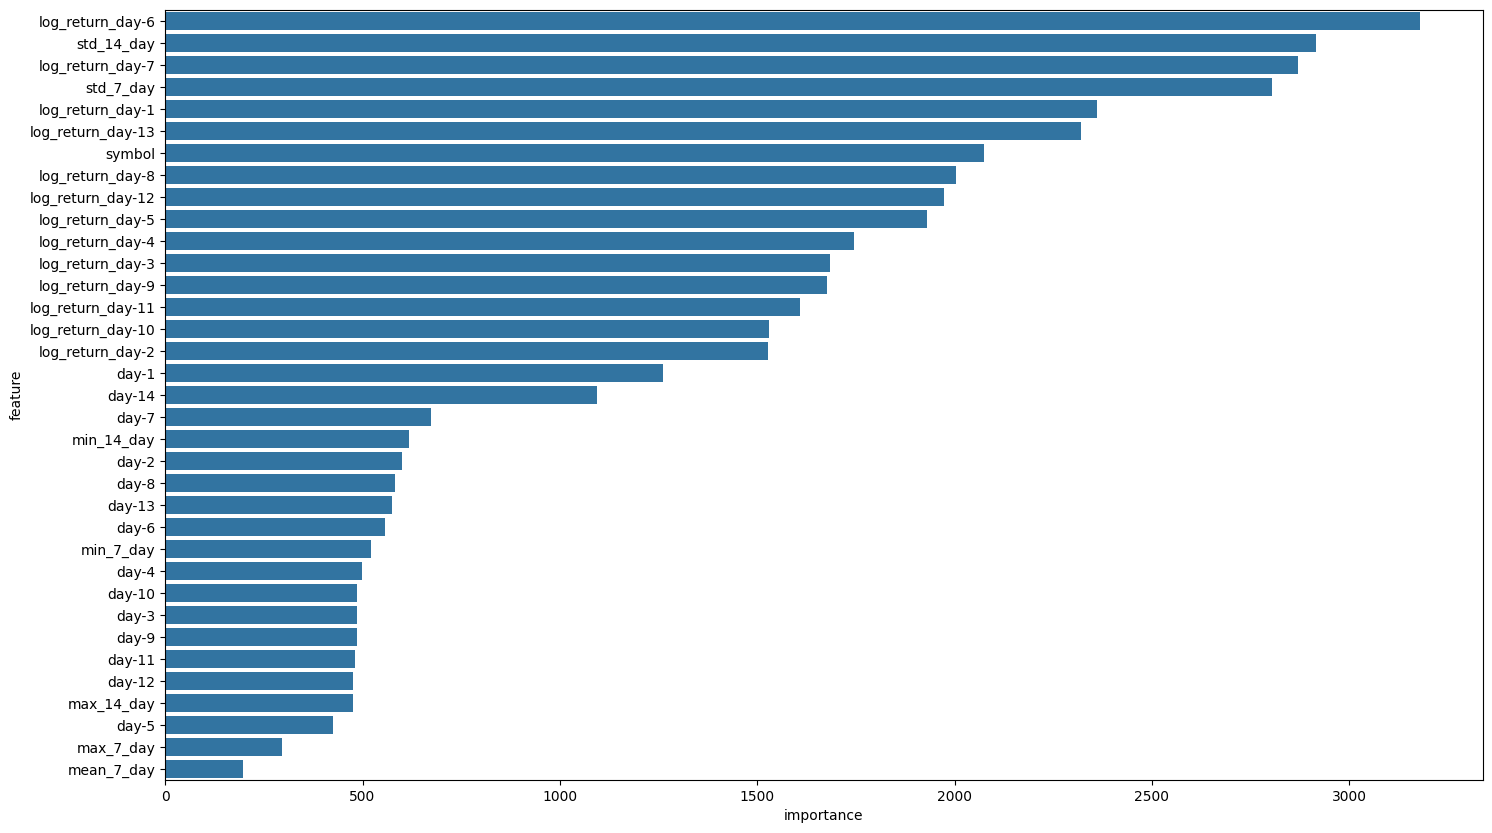

In [ ]:
df_feature_importance = (
    pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_,
    })
    .sort_values('importance', ascending=False)
)
plt.figure(figsize=(17,10))
sns.barplot(x='importance', y='feature', data=df_feature_importance)

In [ ]:
future_dates = pd.date_range('2021-10-30', '2021-11-30')

In [ ]:
for date in future_dates:
    print(date)
    X_test = []
    X_test_symbol = []
    for symbol in symbols:
        feat_14_day = df_horizontal_symbols.tail(14)[symbol].to_list()
        feats = make_feature(feat_14_day)
        X_test.append(feats)
        X_test_symbol.append(symbol)
    X_test = pd.DataFrame(X_test)
    X_test.columns = column_names
    X_test['symbol'] = X_test_symbol
    X_test['symbol'] = X_test['symbol'].astype('category')
    nextday = pd.DataFrame({'symbol': symbols,
                        'Predicted': model.predict(X_test),
                        'date': [date]*len(symbols)})
    nextday_horizontal_symbols = pd.pivot_table(nextday,
               index = 'date',
               columns = 'symbol',
               values = 'Predicted',
               aggfunc = {
                   'Predicted': lambda x: x
               }
              )
    df_horizontal_symbols = pd.concat([df_horizontal_symbols, nextday_horizontal_symbols])

2021-10-30 00:00:00
2021-10-31 00:00:00
2021-11-01 00:00:00
2021-11-02 00:00:00
2021-11-03 00:00:00
2021-11-04 00:00:00
2021-11-05 00:00:00
2021-11-06 00:00:00
2021-11-07 00:00:00
2021-11-08 00:00:00
2021-11-09 00:00:00
2021-11-10 00:00:00
2021-11-11 00:00:00
2021-11-12 00:00:00
2021-11-13 00:00:00
2021-11-14 00:00:00
2021-11-15 00:00:00
2021-11-16 00:00:00
2021-11-17 00:00:00
2021-11-18 00:00:00
2021-11-19 00:00:00
2021-11-20 00:00:00
2021-11-21 00:00:00
2021-11-22 00:00:00
2021-11-23 00:00:00
2021-11-24 00:00:00
2021-11-25 00:00:00
2021-11-26 00:00:00
2021-11-27 00:00:00
2021-11-28 00:00:00
2021-11-29 00:00:00
2021-11-30 00:00:00


In [ ]:
df_horizontal_symbols.reset_index(inplace=True)
df_horizontal_symbols.rename(columns={'index':'date'},inplace=True)

In [ ]:
predictions = df_horizontal_symbols.tail(30).melt(id_vars=['date'],value_name='Predicted')
predictions['Id'] = predictions['date'].astype(str) + ':' + predictions['symbol']

In [ ]:
test_price['Id'] = test_price['date'].astype(str) + ':' + test_price['symbol']
test_price = test_price.merge(predictions[['Id','Predicted']],how='left',on='Id')

In [ ]:
mean_all = ["TCH","SSI","MWG","HDB","POW"]
others = set(symbols)  - set(mean_all)
mean_full_predict = train_price[train_price['symbol'].isin(mean_all)].groupby(['symbol'])['close'].apply(lambda x: np.mean(list(x))).reset_index()
mean_full_predict.columns = ['symbol', 'topping']
mean_last14_predict = train_price[train_price['symbol'].isin(others)].groupby(['symbol'])['close'].apply(lambda x: np.mean(list(x)[-14:])).reset_index()
mean_last14_predict.columns = ['symbol', 'topping']

In [ ]:
topping = pd.concat([mean_full_predict, mean_last14_predict],axis=0).fillna(0)

In [ ]:
test_price = test_price.merge(topping,how='left',on='symbol')

In [ ]:
test_price['Predicted'] = (test_price['Predicted'] + test_price['topping']) / 2

In [ ]:
test_price[['Id','Predicted']].to_csv('/content/drive/MyDrive/SIC_share/sub.csv',index=False)